A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/pedrogengo).

# SETUP

In [ ]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && sed -i '493s/logging/project/' /content/lora/training_scripts/train_lora_dreambooth.py && pip install /content/lora -q
!pip install accelerate bitsandbytes lpips torchmetrics -q
!git clone https://github.com/google/dreambooth.git
!git clone https://github.com/huggingface/diffusers.git
!pip install git+https://github.com/huggingface/diffusers -q

In [2]:
import torch

SEED = 42 #@param{type: 'number'}

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# TRAINING

In [6]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
INSTANCE_TOKEN="hta" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="dreambooth/dataset/dog3" #@param{type: 'string'}

CLASS_PROMPT="dog" #@param{type: 'string'}
CLASS_DIR="dog" #@param{type: 'string'}

OUTPUT_DIR="output" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

In [ ]:

TRAINING_SCRIPT = 'diffusers/examples/dreambooth/train_dreambooth_lora.py' #@param ['diffusers/examples/dreambooth/train_dreambooth_lora.py', 'lora/training_scripts/train_lora_dreambooth.py']

LORA_RANK_KEY = 'lora_rank'
if TRAINING_SCRIPT == 'diffusers/examples/dreambooth/train_dreambooth_lora.py':
  LORA_RANK_KEY = 'rank'

#@markdown ----
STEPS = 800 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}
GRADIENT_ACCUMULATION_STEPS = 2 #@param {type: 'integer'}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 1e-4 #@param {type:"number"}
LR_SCHEDULER = 'constant' #@param  ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}
#@markdown ----
#@markdown LORA PARAMS
LORA_RANK = 16 #@param {type: 'integer'}
WITH_PRIOR_PRESERVATION = False #@param {type: 'boolean'}
#@markdown PRIOR PARAMS
NUM_CLASS_IMAGES = 200 #@param {type: 'integer'}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

command = (f'accelerate launch {TRAINING_SCRIPT} '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="a photo of {INSTANCE_TOKEN} {CLASS_PROMPT}" '
             f'--resolution={RESOLUTION} '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size={BATCH_SIZE} '
             f'--gradient_accumulation_steps={GRADIENT_ACCUMULATION_STEPS} '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="{LR_SCHEDULER}" '
             f'--lr_warmup_steps=0 '
             f'--use_8bit_adam '
             f'--max_train_steps={STEPS} '
             f'--{LORA_RANK_KEY}={LORA_RANK} '
             f'--seed={SEED} '
             f'--gradient_checkpointing ')
if TRAIN_TEXT_ENCODER:
  command += '--train_text_encoder '
  if TRAINING_SCRIPT == 'lora/training_scripts/train_lora_dreambooth.py':
    command += f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} '

if WITH_PRIOR_PRESERVATION:
  command += f'--with_prior_preservation --prior_loss_weight=1.0 ' \
             f'--class_data_dir="{CLASS_DIR}" ' \
             f'--class_prompt="a photo of {CLASS_PROMPT}" ' \
             f'--num_class_images={NUM_CLASS_IMAGES} '

!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

# INFERENCE

In [ ]:
#@title LOADING MODEL AND MONKEY PATCHING IT (lora/training_scripts/train_dreambooth.py)
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

In [ ]:
#@title LOADING MODEL AND LORA WEIGHTS (diffusers/examples/dreambooth/train_dreambooth_lora.py)
from diffusers import StableDiffusionPipeline
from lora_diffusion import tune_lora_scale


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
pipe.load_lora_weights('/content/pytorch_lora_weights.safetensors')
pipe.safety_checker = None

In [ ]:
INFERENCE_PROMPT = 'hta dog' #@param {type:"string"}
LORA_SCALE_UNET = 0.37 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.26 #@param {type:"number"}
GUIDANCE = 7 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

# Evaluation

In [ ]:
#@markdown Is object alive?
ALIVE = True #@param{type: "boolean"}

def get_prompt_list(unique_token, class_token, alive):
  if alive:
    prompt_list = [
      'a {0} {1} in the jungle'.format(unique_token, class_token),
      'a {0} {1} in the snow'.format(unique_token, class_token),
      'a {0} {1} on the beach'.format(unique_token, class_token),
      'a {0} {1} on a cobblestone street'.format(unique_token, class_token),
      'a {0} {1} on top of pink fabric'.format(unique_token, class_token),
      'a {0} {1} on top of a wooden floor'.format(unique_token, class_token),
      'a {0} {1} with a city in the background'.format(unique_token, class_token),
      'a {0} {1} with a mountain in the background'.format(unique_token, class_token),
      'a {0} {1} with a blue house in the background'.format(unique_token, class_token),
      'a {0} {1} on top of a purple rug in a forest'.format(unique_token, class_token),
      'a {0} {1} wearing a red hat'.format(unique_token, class_token),
      'a {0} {1} wearing a santa hat'.format(unique_token, class_token),
      'a {0} {1} wearing a rainbow scarf'.format(unique_token, class_token),
      'a {0} {1} wearing a black top hat and a monocle'.format(unique_token, class_token),
      'a {0} {1} in a chef outfit'.format(unique_token, class_token),
      'a {0} {1} in a firefighter outfit'.format(unique_token, class_token),
      'a {0} {1} in a police outfit'.format(unique_token, class_token),
      'a {0} {1} wearing pink glasses'.format(unique_token, class_token),
      'a {0} {1} wearing a yellow shirt'.format(unique_token, class_token),
      'a {0} {1} in a purple wizard outfit'.format(unique_token, class_token),
      'a red {0} {1}'.format(unique_token, class_token),
      'a purple {0} {1}'.format(unique_token, class_token),
      'a shiny {0} {1}'.format(unique_token, class_token),
      'a wet {0} {1}'.format(unique_token, class_token),
      'a cube shaped {0} {1}'.format(unique_token, class_token)
    ]
  else:
    prompt_list = [
      'a {0} {1} in the jungle'.format(unique_token, class_token),
      'a {0} {1} in the snow'.format(unique_token, class_token),
      'a {0} {1} on the beach'.format(unique_token, class_token),
      'a {0} {1} on a cobblestone street'.format(unique_token, class_token),
      'a {0} {1} on top of pink fabric'.format(unique_token, class_token),
      'a {0} {1} on top of a wooden floor'.format(unique_token, class_token),
      'a {0} {1} with a city in the background'.format(unique_token, class_token),
      'a {0} {1} with a mountain in the background'.format(unique_token, class_token),
      'a {0} {1} with a blue house in the background'.format(unique_token, class_token),
      'a {0} {1} on top of a purple rug in a forest'.format(unique_token, class_token),
      'a {0} {1} with a wheat field in the background'.format(unique_token, class_token),
      'a {0} {1} with a tree and autumn leaves in the background'.format(unique_token, class_token),
      'a {0} {1} with the Eiffel Tower in the background'.format(unique_token, class_token),
      'a {0} {1} floating on top of water'.format(unique_token, class_token),
      'a {0} {1} floating in an ocean of milk'.format(unique_token, class_token),
      'a {0} {1} on top of green grass with sunflowers around it'.format(unique_token, class_token),
      'a {0} {1} on top of a mirror'.format(unique_token, class_token),
      'a {0} {1} on top of the sidewalk in a crowded street'.format(unique_token, class_token),
      'a {0} {1} on top of a dirt road'.format(unique_token, class_token),
      'a {0} {1} on top of a white rug'.format(unique_token, class_token),
      'a red {0} {1}'.format(unique_token, class_token),
      'a purple {0} {1}'.format(unique_token, class_token),
      'a shiny {0} {1}'.format(unique_token, class_token),
      'a wet {0} {1}'.format(unique_token, class_token),
      'a cube shaped {0} {1}'.format(unique_token, class_token)
    ]
  return prompt_list


instance_prompt_list = get_prompt_list(INSTANCE_TOKEN, CLASS_PROMPT, alive=ALIVE)
prior_prompt_list = get_prompt_list('', CLASS_PROMPT, alive=ALIVE)

In [ ]:
GENERATED_PRIOR_DIR = "generated_prior" #@param{type: 'string'}
GENERATED_INSTANCE_DIR = "generated_instance" #@param{type: 'string'}

%mkdir -p $GENERATED_PRIOR_DIR
%mkdir -p $GENERATED_INSTANCE_DIR

In [ ]:
NUM_IMAGES_PER_PROMPT=4 #@param{type: "integer"}

i = 0
for prompt in instance_prompt_list:
  images = pipe(prompt, num_inference_steps=50, guidance_scale=GUIDANCE, num_images_per_prompt=NUM_IMAGES_PER_PROMPT).images
  for image in images:
    image.save(os.path.join(GENERATED_INSTANCE_DIR, f'{i}.jpg'))
    i += 1

i = 0
for prompt in prior_prompt_list:
  images = pipe(prompt, num_inference_steps=50, guidance_scale=GUIDANCE, num_images_per_prompt=NUM_IMAGES_PER_PROMPT).images
  for image in images:
    image.save(os.path.join(GENERATED_PRIOR_DIR, f'{i}.jpg'))
    i += 1

!rm -rf $GENERATED_INSTANCE_DIR/.ipynb_checkpoints
!rm -rf $GENERATED_PRIOR_DIR/.ipynb_checkpoints

In [ ]:
from transformers import (
    ViTImageProcessor, ViTModel,
    CLIPImageProcessor, CLIPVisionModelWithProjection,
    CLIPTokenizer, CLIPTextModelWithProjection
    )
from sklearn.metrics.pairwise import cosine_similarity
import lpips
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchvision.transforms.functional import to_tensor
from PIL import Image


DINO_MODEL = 'facebook/dino-vits16' #@param{type: 'string'}
CLIP_MODEL = 'openai/clip-vit-base-patch16' #@param{type: 'string'}
LPIPS_NET_TYPE = 'alex' #@param ['vgg', 'alex', 'squeeze']

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lpips = LearnedPerceptualImagePatchSimilarity(net_type=LPIPS_NET_TYPE, reduction='mean', normalize=True).to(device)

dino_processor = ViTImageProcessor.from_pretrained(DINO_MODEL)
dino = ViTModel.from_pretrained(DINO_MODEL, add_pooling_layer=False).to(device)

clip_processor = CLIPImageProcessor.from_pretrained(CLIP_MODEL)
clip = CLIPVisionModelWithProjection.from_pretrained(CLIP_MODEL).to(device)


clip_tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL)
clip_text = CLIPTextModelWithProjection.from_pretrained(CLIP_MODEL).to(device)

def clip_i_metric(generated_images_dir, instance_dir):
  instance_embeds_list = []
  for image_path in sorted(os.listdir(instance_dir), key=lambda x: int(x.split('.')[0])):
    image = Image.open(os.path.join(instance_dir, image_path))
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    outputs = clip(**inputs)
    image_embeds = outputs.image_embeds[0]
    instance_embeds_list.append(image_embeds.detach().cpu())
  instance_embeds = torch.stack(instance_embeds_list)

  generated_embeds_list = []
  for image_path in sorted(os.listdir(generated_images_dir), key=lambda x: int(x.split('.')[0])):
    image = Image.open(os.path.join(generated_images_dir, image_path))
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    outputs = clip(**inputs)
    image_embeds = outputs.image_embeds[0]
    generated_embeds_list.append(image_embeds.detach().cpu())
  generated_embeds = torch.stack(generated_embeds_list)

  metric = cosine_similarity(instance_embeds, generated_embeds).mean()
  return metric


def dino_metric(generated_images_dir, instance_dir):
  instance_embeds_list = []
  for image_path in sorted(os.listdir(instance_dir), key=lambda x: int(x.split('.')[0])):
    image = Image.open(os.path.join(instance_dir, image_path))
    inputs = dino_processor(images=image, return_tensors="pt").to(device)
    outputs = dino(**inputs)
    image_embeds = outputs.last_hidden_state[0, 0]
    instance_embeds_list.append(image_embeds.detach().cpu())
  instance_embeds = torch.stack(instance_embeds_list)

  generated_embeds_list = []
  for image_path in sorted(os.listdir(generated_images_dir), key=lambda x: int(x.split('.')[0])):
    image = Image.open(os.path.join(generated_images_dir, image_path))
    inputs = dino_processor(images=image, return_tensors="pt").to(device)
    outputs = dino(**inputs)
    image_embeds = outputs.last_hidden_state[0, 0]
    generated_embeds_list.append(image_embeds.detach().cpu())
  generated_embeds = torch.stack(generated_embeds_list)

  metric = cosine_similarity(instance_embeds, generated_embeds).mean()
  return metric


def div_metric(instance_dir):
  instance_images = []
  for image_path in sorted(os.listdir(instance_dir), key=lambda x: int(x.split('.')[0])):
    instance_images.append(to_tensor(Image.open(os.path.join(instance_dir, image_path))).unsqueeze(0).to(device))

  len_prompts = 0
  mean_similarity = 0

  for i in range(0, len(instance_images), NUM_IMAGES_PER_PROMPT):
    len_per_prompt = 0
    mean_per_prompt = 0
    for j1 in range(NUM_IMAGES_PER_PROMPT):
      for j2 in range(j1 + 1, NUM_IMAGES_PER_PROMPT):
        mean_per_prompt += lpips(instance_images[j1], instance_images[j2])
        len_per_prompt += 1
    mean_per_prompt /= len_per_prompt
    len_prompts += 1
    mean_similarity += mean_per_prompt

  for i in range(len(instance_images)):
    instance_images[i] = instance_images[i].to('cpu')
  del instance_images
  torch.cuda.empty_cache()

  mean_similarity /= len_prompts
  return mean_similarity.item()


def clip_t_metric(prompts, generated_images_dir):
  images_embeds_list = []
  for image_path in sorted(os.listdir(generated_images_dir), key=lambda x: int(x.split('.')[0])):
    image = Image.open(os.path.join(generated_images_dir, image_path))
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    outputs = clip(**inputs)
    image_embeds = outputs.image_embeds[0]
    images_embeds_list.append(image_embeds.detach().cpu())
  images_embeds = torch.stack(images_embeds_list)

  tokens = clip_tokenizer(prompts, return_tensors='pt', padding=True).to(device)
  outputs = clip_text(**tokens)
  text_embeds = outputs.text_embeds.detach().cpu()

  metric = cosine_similarity(images_embeds, text_embeds).mean()
  return metric


In [ ]:
PRES_METRIC = dino_metric(GENERATED_PRIOR_DIR, INSTANCE_DIR)
PRES_METRIC

In [ ]:
DIV_METRIC = div_metric(GENERATED_INSTANCE_DIR)
DIV_METRIC

In [ ]:
DINO_METRIC = dino_metric(GENERATED_INSTANCE_DIR, INSTANCE_DIR)
DINO_METRIC

In [ ]:
CLIP_I_METRIC = clip_i_metric(GENERATED_INSTANCE_DIR, INSTANCE_DIR)
CLIP_I_METRIC

In [ ]:
CLIP_T_METRIC = (clip_t_metric(instance_prompt_list, GENERATED_INSTANCE_DIR) + clip_t_metric(prior_prompt_list, GENERATED_PRIOR_DIR)) / 2
CLIP_T_METRIC

# Bonus part

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline


i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained('radames/stable-diffusion-v1-5-img2img', torch_dtype=torch.float16).to("cuda")
i2i_pipe.safety_checker = None

  0%|          | 0/50 [00:00<?, ?it/s]

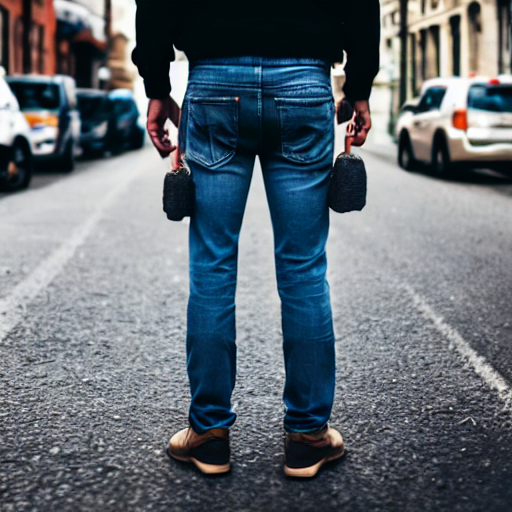

In [ ]:
images = pipe(prompt="a man in jeans on the street at the morning", guidance_scale=7).images
images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

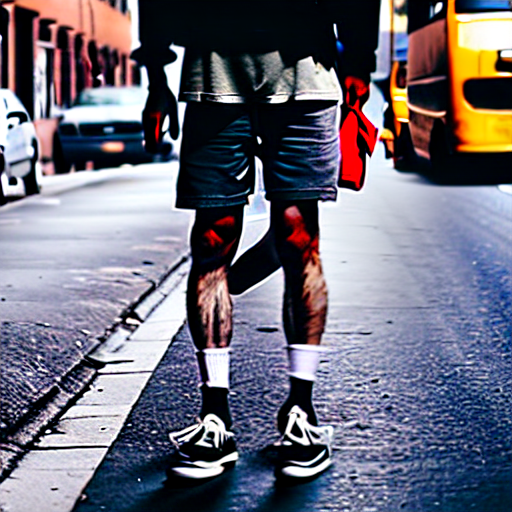

In [ ]:
styled_images = i2i_pipe(prompt="a man in shorts on the street at the morning", image=images[0], strength=0.75, guidance_scale=75).images
styled_images[0]